In [1]:
import pandas as pd
from gensim.models import Word2Vec as wv
import bamboolib
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
from bunkatech.semantics.extract_terms import extract_terms_df
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go


#### Word2Vec

In [2]:
"""

final = [doc.split() for doc in docs]
model = wv(
    sentences=final, vector_size=100, window=10, min_count=3, workers=8, epochs=15
)

my_dict = dict({})
for idx, key in enumerate(model.wv.key_to_index):
    my_dict[key] = model.wv[key]
    
emb = pd.DataFrame(my_dict).T
df_emb = cosine_similarity(emb)
df_emb = pd.DataFrame(df_emb)
df_emb.columns = emb.index
df_emb.index = emb.index

"""

'\n\nfinal = [doc.split() for doc in docs]\nmodel = wv(\n    sentences=final, vector_size=100, window=10, min_count=3, workers=8, epochs=15\n)\n\nmy_dict = dict({})\nfor idx, key in enumerate(model.wv.key_to_index):\n    my_dict[key] = model.wv[key]\n    \nemb = pd.DataFrame(my_dict).T\ndf_emb = cosine_similarity(emb)\ndf_emb = pd.DataFrame(df_emb)\ndf_emb.columns = emb.index\ndf_emb.index = emb.index\n\n'

#### Sbert

In [3]:
data = pd.read_csv(
    "/Users/charlesdedampierre/Desktop/ENS Projects/imaginary-world/db_film_iw (2).csv",
    index_col=[0],
)


text_var = 'description'
data = data[data[text_var].notna()]
docs = data[text_var].to_list()



In [4]:
terms = extract_terms_df(
        data,
        text_var=text_var,
        limit=10000,
        sample_size=10000,
        ngs=True,  # ngrams
        ents=True,  # entities
        ncs=True,  # nouns
        drop_emoji=True,
        remove_punctuation=False,
        ngrams=(1, 2),
        include_pos=["NOUN", "PROPN", "ADJ"],
        include_types=["PERSON", "ORG"],
        language="en",
    )


Extract Terms: 100%|████████████████████████| 9401/9401 [02:36<00:00, 60.05it/s]


In [5]:
bert_model = "distiluse-base-multilingual-cased-v1"

terms["bindex"] = terms.index
# embed the temrs with sbert
model = SentenceTransformer(bert_model)
docs = list(terms["main form"])
terms_embeddings = model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [6]:
docs_prepro = [x.lower() for x in docs]

df_bert = cosine_similarity(terms_embeddings)
df_bert = pd.DataFrame(df_bert)
df_bert.columns = docs_prepro
df_bert.index = docs_prepro

In [7]:
scaler = MinMaxScaler(feature_range = (-1, 1))

In [8]:
def bourdieu_projection(df_bert, projection, projection_2, term_var = 'term'):
    """
    
    Project the terms on two opposite dimensions
    
    """

    projection_str = '-'.join(projection)
    projection_str_2 = '-'.join(projection_2)

    df_proj = df_bert[projection + projection_2]
    df_proj[projection_str] = df_proj[projection[0]] - df_proj[projection[1]]
    df_proj[projection_str_2] = df_proj[projection_2[0]] - df_proj[projection_2[1]]

    df_proj[term_var] = df_proj.index
    df_proj = df_proj.sort_values(projection_str_2, ascending=True)
    df_proj[projection_str] = scaler.fit_transform(df_proj[projection_str].values.reshape(-1,1))
    df_proj[projection_str_2] = scaler.fit_transform(df_proj[projection_str_2].values.reshape(-1,1))


    fig = go.Figure()

    trace_1 = go.Scatter(
        x=[-1.1, 1.1],
        y=[0, 0],
        mode="lines",
        line_color="grey",
        name =projection_str)


    trace_2 = go.Scatter(
        x=[0, 0],
        y=[-1.1, 1.1],
        mode="lines",
        line_color="grey",
        name =projection_str_2)

    trace_scatter = go.Scatter(
        x=df_proj[projection_str],
        y=df_proj[projection_str_2],
        text = df_proj[term_var],
        mode="markers",
        name = 'terms')

    fig.add_trace(trace_scatter)
    fig.add_trace(trace_1)
    fig.add_trace(trace_2)


    fig.update_layout(
            title='Bourdieu Projection',
            height=1000,
            width=1000,
            xaxis_title=projection_str,
            yaxis_title=projection_str_2,
        )

    return fig


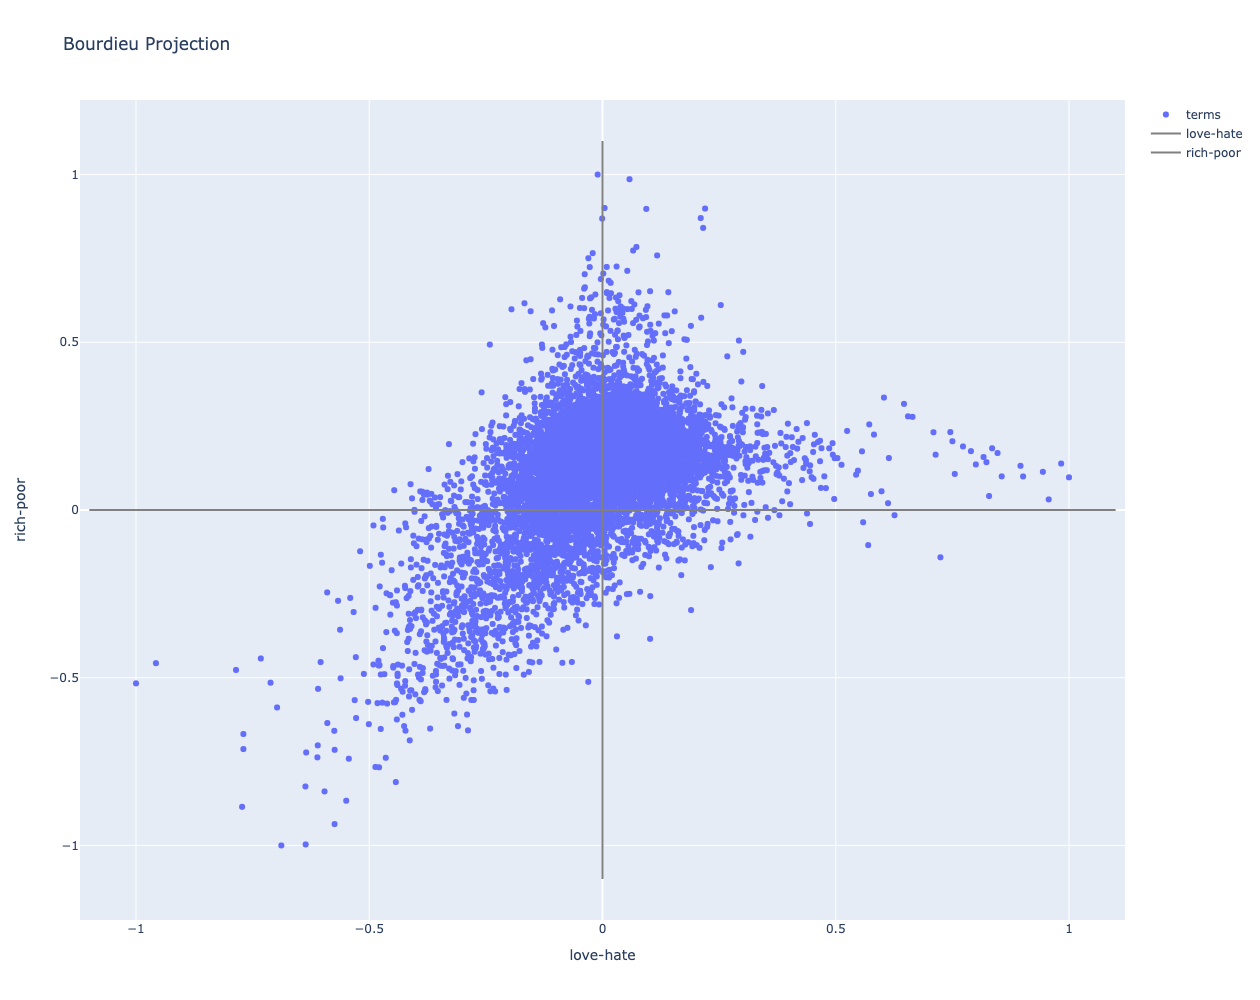

In [9]:
projection = ['love', 'hate'] 
projection_2 = ['rich', 'poor']

fig = bourdieu_projection(df_bert, projection, projection_2, term_var = 'term')

fig.show()

In [10]:

import plotly
plotly.offline.plot(fig, filename = 'bourdieu_projection.html', auto_open=False)

'bourdieu_projection.html'

In [11]:
#fig = px.scatter(df_proj, x = projection_str, y= projection_str_2,  hover_data = ['term'], height = 800, width = 800)

In [12]:
# Index to project the movies

In [13]:
from bunkatech.semantics.indexer import indexer

df_terms = terms.copy()
df_terms["text"] = df_terms["text"].apply(lambda x: x.split(" | "))
df_terms = df_terms.explode("text").reset_index(drop=True)
list_terms = df_terms["text"].tolist()

# Index the extracted terms
df_indexed = indexer(data[text_var].tolist(), list_terms, db_path='.')

df_indexed_full = pd.merge(
        df_indexed, df_terms, left_on="words", right_on="text"
    )
df_indexed_full = df_indexed_full[["docs", "lemma", "main form", "text"]].copy()
df_enrich = pd.merge(data, df_indexed_full, left_on=text_var, right_on="docs")

In [14]:
test = df_enrich[['imdb', 'original_title', 'description', 'main form']]
test['main form'] = test['main form'].apply(lambda x : x.lower())


In [60]:
df_proj = df_bert.copy()

projection = ['past', 'future'] 
projection_2 = ['hope', 'despair']
term_var = 'term'

projection_str = '-'.join(projection)
projection_str_2 = '-'.join(projection_2)

df_proj = df_bert[projection + projection_2]
df_proj[projection_str] = df_proj[projection[0]] - df_proj[projection[1]]
df_proj[projection_str_2] = df_proj[projection_2[0]] - df_proj[projection_2[1]]

df_proj[term_var] = df_proj.index
df_proj = df_proj.sort_values(projection_str_2, ascending=True)
df_proj[projection_str] = scaler.fit_transform(df_proj[projection_str].values.reshape(-1,1))
df_proj[projection_str_2] = scaler.fit_transform(df_proj[projection_str_2].values.reshape(-1,1))

In [61]:
fin = pd.merge(df_proj[['term', projection_str, projection_str_2]], test, left_on = 'term', right_on = 'main form')
fin

term  past-future  hope-despair       imdb    original_title  \
0        disruption     0.024416     -1.000000  tt0055928            Dr. No   
1        disruption     0.024416     -1.000000  tt0213682           Gohatto   
2       destructive     0.135047     -0.992381  tt0015881             Greed   
3       destructive     0.135047     -0.992381  tt0049513         Moby Dick   
4       destructive     0.135047     -0.992381  tt0074102      Ai no korîda   
...             ...          ...           ...        ...               ...   
165080         hope    -0.461422      1.000000  tt6499752           Upgrade   
165081         hope    -0.461422      1.000000  tt6781982      Night School   
165082         hope    -0.461422      1.000000  tt6781982      Night School   
165083         hope    -0.461422      1.000000  tt7838252  K.G.F: Chapter 1   
165084         hope    -0.461422      1.000000  tt7838252  K.G.F: Chapter 1   

                                              description    main form  
0       A resourceful British government agent seeks a...   disruption  
1       The new member of a samurai militia unit cause...   disruption  
2       The sudden fortune won from a lottery fans suc...  destructive  
3       The sole survivor of a lost whaling ship relat...  destructive  
4       A passionate telling of the story of Sada Abe,...  destructive  
...                                                   ...          ...  
165080  Set in the near-future, technology controls ne...         hope  
165081  A group of high school dropouts are forced to ...         hope  
165082  A group of high school dropouts are forced to ...         hope  
165083  In the 1970s, a fierce rebel rises against bru...         hope  
165084  In the 1970s, a fierce rebel rises against bru...         hope  

[165085 rows x 7 columns]

In [62]:
res = fin.groupby(['imdb', 'description']).agg(projection_str = (projection_str, 'mean'), projection_str_2 = (projection_str_2, 'mean')).reset_index()
res = res.rename(columns = {'projection_str':projection_str, 'projection_str_2':projection_str_2})

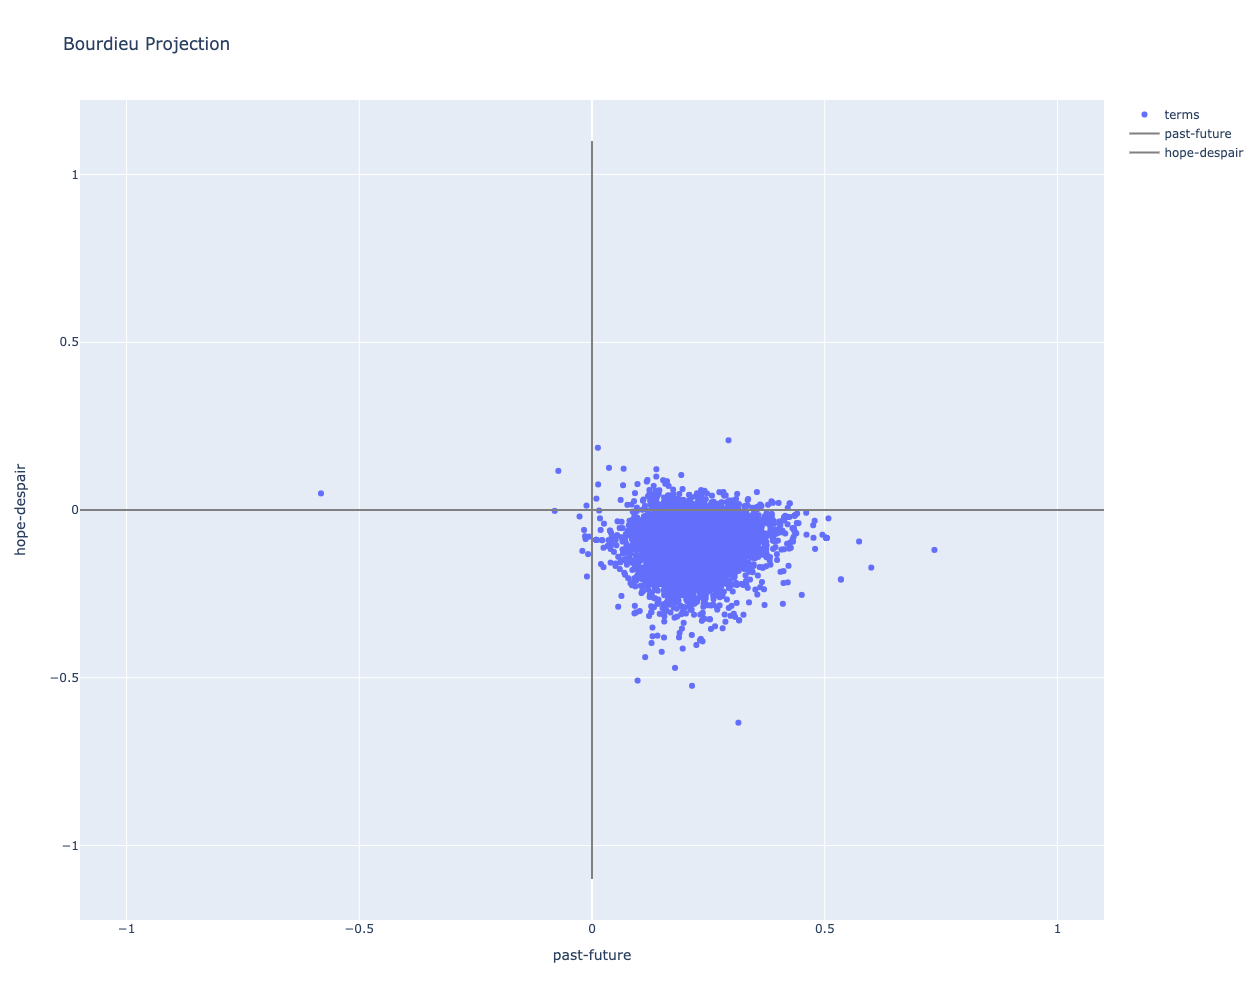

In [63]:
fig = go.Figure()

trace_1 = go.Scatter(
    x=[-1.1, 1.1],
    y=[0, 0],
    mode="lines",
    line_color="grey",
    name =projection_str)

trace_2 = go.Scatter(
    x=[0, 0],
    y=[-1.1, 1.1],
    mode="lines",
    line_color="grey",
    name =projection_str_2)

trace_scatter = go.Scatter(
    x=res[projection_str],
    y=res[projection_str_2],
    text = res[text_var],
    mode="markers",
    name = 'terms')

fig.add_trace(trace_scatter)
fig.add_trace(trace_1)
fig.add_trace(trace_2)


fig.update_layout(
        title='Bourdieu Projection',
        height=1000,
        width=1000,
        xaxis_title=projection_str,
        yaxis_title=projection_str_2,
    )


In [64]:
plotly.offline.plot(fig, filename = 'bourdieu_projection.html', auto_open=False)

'bourdieu_projection.html'